/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


1000
{'W': 0, 'Q': 1, 'S': 2, 'F': 3, 'Y': 4, 'Z': 5, 'N': 6, 'C': 7, 'A': 8, 'I': 9, 'X': 10, 'B': 11, 'G': 12, 'V': 13, 'L': 14, 'T': 15, '-': 16, 'P': 17, 'E': 18, 'M': 19, 'R': 20, 'D': 21, 'H': 22, 'K': 23}
{0: 'W', 1: 'Q', 2: 'S', 3: 'F', 4: 'Y', 5: 'Z', 6: 'N', 7: 'C', 8: 'A', 9: 'I', 10: 'X', 11: 'B', 12: 'G', 13: 'V', 14: 'L', 15: 'T', 16: '-', 17: 'P', 18: 'E', 19: 'M', 20: 'R', 21: 'D', 22: 'H', 23: 'K'}


/home/kbadal/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Train Loss: 0.3972, Train Acc: 0.9029, Val Loss: 0.2187, Val Acc: 0.9475
Epoch 1: Train Loss: 0.1825, Train Acc: 0.9533, Val Loss: 0.1425, Val Acc: 0.9654
Epoch 2: Train Loss: 0.1382, Train Acc: 0.9650, Val Loss: 0.1184, Val Acc: 0.9720
Epoch 3: Train Loss: 0.1175, Train Acc: 0.9699, Val Loss: 0.1044, Val Acc: 0.9744
Epoch 4: Train Loss: 0.1105, Train Acc: 0.9720, Val Loss: 0.1015, Val Acc: 0.9757
Epoch 5: Train Loss: 0.1031, Train Acc: 0.9738, Val Loss: 0.0892, Val Acc: 0.9778
Epoch 6: Train Loss: 0.0856, Train Acc: 0.9776, Val Loss: 0.0859, Val Acc: 0.9785
Epoch 7: Train Loss: 0.0828, Train Acc: 0.9779, Val Loss: 0.0790, Val Acc: 0.9801
Epoch 8: Train Loss: 0.0735, Train Acc: 0.9804, Val Loss: 0.0738, Val Acc: 0.9809
Epoch 9: Train Loss: 0.0709, Train Acc: 0.9807, Val Loss: 0.0686, Val Acc: 0.9822
Epoch 10: Train Loss: 0.0694, Train Acc: 0.9813, Val Loss: 0.0702, Val Acc: 0.9821
Epoch 11: Train Loss: 0.0623, Train Acc: 0.9831, Val Loss: 0.0667, Val Acc: 0.9829
Epoch 12: Trai

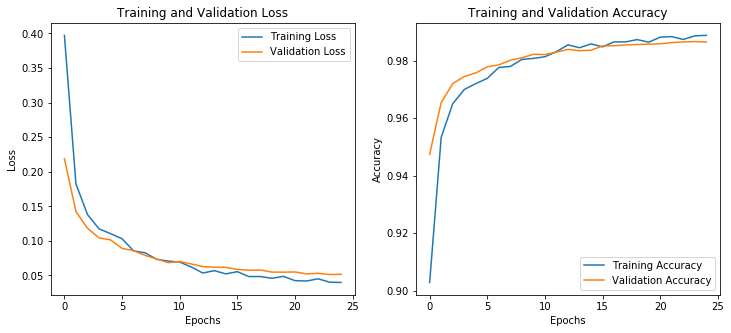

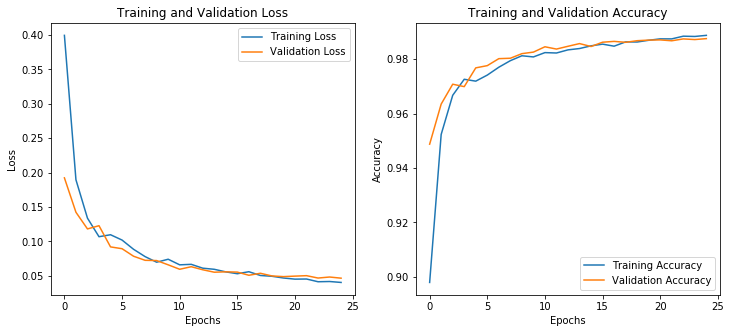

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2Model, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, AdamW
import numpy as np
import matplotlib.pyplot as plt
import random

def train(filename):
    def get_sequences(file_name):
        sequences = []
        with open(file_name, "r") as input_file:
            lines = list(filter(None, input_file.read().split("\n")))
            parts = []
            for line in lines:
                if line.startswith(">"):
                    if parts:
                        sequences.append("".join(parts))
                    parts = []
                else:
                    parts.append(line)
            if parts:
                sequences.append("".join(parts))
        return sequences

    def introduce_gaps_and_errors(sequence, gap_probability=0.1, error_probability=0.05):
        new_sequence = []
        valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
        
        for i, aa in enumerate(sequence):
            # Check if we are in the last three characters of the sequence
            if i >= len(sequence) - 3:
                new_sequence.append('-')  # Add a gap for the last three characters
            else:
                # Original logic for other characters
                if np.random.rand() < gap_probability:
                    new_sequence.append('-')
                else:
                    if np.random.rand() < error_probability and aa in valid_amino_acids:
                        new_sequence.append(random.choice(list(valid_amino_acids - {aa})))
                    else:
                        new_sequence.append(aa)
        
        return ''.join(new_sequence)

    def custom_tokenize(sequence, char_to_int, max_length=512):
        token_ids = [char_to_int.get(char, char_to_int.get('-')) for char in sequence]
        if len(token_ids) > max_length:
            token_ids = token_ids[:max_length]
        padded_token_ids = token_ids + [char_to_int.get('-')] * (max_length - len(token_ids))
        return padded_token_ids

    training_sequences = get_sequences(filename+".txt")
    print(len(training_sequences))
    all_chars = set("".join(training_sequences) + "-")
    NUM_CLASSES = len(all_chars)
    CHAR_TO_INT = {c: i for i, c in enumerate(all_chars)}
    INT_TO_CHAR = {v: k for k, v in CHAR_TO_INT.items()}
    print(CHAR_TO_INT)
    print(INT_TO_CHAR)
    gapped_sequences = []
    new_data = []
    for seq in training_sequences:
        gapped_sequences.append(seq)
        gapped_sequences.append(introduce_gaps_and_errors(seq, gap_probability=(0.0) , error_probability=0.07))
        new_data.append(seq)
        new_data.append(seq)
        for i in range(0,4):
            gapped_sequences.append(introduce_gaps_and_errors(seq, gap_probability=(0.1+(i/10)) , error_probability=0.1-(i/100)))
            new_data.append(seq)


    class ProteinDataset(Dataset):
        def __init__(self, sequences, gapped_sequences):
            self.sequences = sequences
            self.gapped_sequences = gapped_sequences

        def __len__(self):
            return len(self.sequences)

        def __getitem__(self, idx):
            return self.gapped_sequences[idx], self.sequences[idx]

    dataset = ProteinDataset(new_data, gapped_sequences)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    # Creating DataLoaders for training and validation sets
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=4)

    model_name = "gpt2-medium"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    config = GPT2Config.from_pretrained(model_name, n_positions=512)
    model = GPT2LMHeadModel(config)

    class GPT2ForProteinPrediction(GPT2LMHeadModel):
        def __init__(self, config):
            super().__init__(config)
            self.lm_head = nn.Linear(config.n_embd, NUM_CLASSES, bias=False)

    model = GPT2ForProteinPrediction(config).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=5e-5)

    def calculate_accuracy(logits, labels):
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions = (predictions == labels).float()
        accuracy = correct_predictions.sum() / correct_predictions.numel()
        return accuracy.item()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(25):
        total_train_loss, total_train_accuracy = 0, 0
        model.train()
        for batch in train_dataloader:
            input_seq, target_seq = batch
            input_tokens = torch.tensor([custom_tokenize(input_seq[0], CHAR_TO_INT)], dtype=torch.long).to(model.device)
            target_tokens = torch.tensor([custom_tokenize(target_seq[0], CHAR_TO_INT)], dtype=torch.long).to(model.device)

            #Clear previous gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_tokens)
            logits = outputs[0]

            # Reshape logits and target for loss calculation
            min_length = min(logits.size(1), target_tokens.size(1))
            logits = logits[:, :min_length, :].contiguous()
            target_tokens = target_tokens[:, :min_length].contiguous()

            # Calculate loss
            train_loss = criterion(logits.view(-1, logits.size(-1)), target_tokens.view(-1))
            total_train_loss += train_loss.item()

            # Backward pass and optimize
            train_loss.backward()
            optimizer.step()

            # Calculate accuracy
            train_accuracy = calculate_accuracy(logits, target_tokens)
            total_train_accuracy += train_accuracy

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        total_val_loss, total_val_accuracy = 0, 0
        model.eval()
        with torch.no_grad():
            for batch in val_dataloader:
                input_seq, target_seq = batch
                input_tokens = torch.tensor([custom_tokenize(input_seq[0], CHAR_TO_INT)], dtype=torch.long).to(
                    model.device)
                target_tokens = torch.tensor([custom_tokenize(target_seq[0], CHAR_TO_INT)], dtype=torch.long).to(
                    model.device)

                # Forward pass
                outputs = model(input_tokens)
                logits = outputs[0]

                # Reshape logits and target for loss calculation
                min_length = min(logits.size(1), target_tokens.size(1))
                logits = logits[:, :min_length, :].contiguous()
                target_tokens = target_tokens[:, :min_length].contiguous()

                # Calculate loss
                val_loss = criterion(logits.view(-1, logits.size(-1)), target_tokens.view(-1))
                total_val_loss += val_loss.item()

                # Calculate accuracy
                val_accuracy = calculate_accuracy(logits, target_tokens)
                total_val_accuracy += val_accuracy
        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, '
            f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')
    torch.save(model.state_dict(), 'protein_gpt_model_'+filename+'.pth')
    model.load_state_dict(torch.load('protein_gpt_model_'+filename+'.pth'))
    model.eval()

    # Create a figure with specified size
    plt.figure(figsize=(12, 5))

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Save the figure
    plt.savefig(filename +'1.png')
    with open("CHAR_TO_INT"+filename+".txt", "w") as input_file:
        input_file.write(str(CHAR_TO_INT)+"\n"+str(train_losses)+"\n"+str(train_accuracies)+"\n"+str(val_losses)+"\n"+str(val_accuracies))
                    
    with open("INT_TO_CHAR"+filename+".txt", "w") as input_file:
        input_file.write(str(INT_TO_CHAR))

import os

# directory = 'data/new'
# files = os.listdir(directory)
# for file in files:
#         temp = file.split(".")
#         print(temp[0])
train("mab_data")
